In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'wind_gyre'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

fac = 1
nx = 64*fac
ny = 64*fac
nt = 1600*fac
nt = 960*30
#nt = 3000

picture_frequency = 0
output_frequency = 500
diagnostic_frequency = output_frequency

dx = 60e3
dy = dx

grav = 10.
rho = np.array([1000.])
#rho = np.array([1., 2., 3.])
nz = rho.size

H0 = 500.
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
#dt  = 0.1*dx/np.sqrt(grav*H0)
#dt = 60.
dt = 90.

nspx = 1
nspy = 1
epsab = 0.01

kh = 1.6e5
Ah = kh
drag_coeff_linear = 4e-6

#lat_0 = 30.
#omega = 2*np.pi/(24.*3600.)     # Earth's angular frequency [s**-1]
#R = 6.371e6                     # Earth's radius [m]
#f0 = 2*omega*np.sin(lat_0*np.pi/180.)
#beta = 2*omega/R*np.cos(lat_0*np.pi/180.)
f0 = 1e-4
beta = 1e-11

print(f'resolution:    {dx/1e3}km')
print(f'Munk layer:    {(Ah/beta)**(1./3.)/1e3}km')
print(f'Stommel layer: {drag_coeff_linear/beta/1e3}km')
if dx>2.*drag_coeff_linear/beta:
  print(f'Resolution too small to resole Stommel layer.')
  sys.exit()

do_momentum_advection = False
do_momentum_diffusion = True
do_momentum_drag = True
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_momentum_windstress = True
do_height_diffusion = False
do_height_advection = True

resolution:    60.0km
Munk layer:    251.98420997897446km
Stommel layer: 400.0km


In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
maskt0[:,:,0] = 0.
maskt0[:,:,-1] = 0.
maskt0[:,0,:] = 0.
maskt0[:,-1,:] = 0.

eta0[0,:,:] = 0.
eta0[nz,:,:] = -H0
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

ho0 *= maskt0

#taux0 = -1e-4*np.cos(2.*np.pi*Yt/Ly * 0.5)
taux0 = -1e-4*np.cos(2.*np.pi*Yt/Ly)

ix = np.array([nx//2])
iy = np.array([ny//2])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

Creating directory /Users/nbruegge/work/movies/shallow_py/wind_gyre/.
ll =  28500/ 28800, Total run time: 2.83min, done at 2022-08-26 13:43:46.000050, ho.sum = 1.9e+06, ke.sum = 9.8e-01, cflu = 5.6e-05, cflv = 7.9e-05
--- All done! ---
Total run time: 2.83min, done at 2022-08-26 13:43:45.875881
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    flist = glob.glob(f'{path_data}/{file_prfx}_????.nc')
    flist.sort()
    ds = xr.open_mfdataset(flist, **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/wind_gyre//shallowpy_combined.nc
CPU times: user 1.29 s, sys: 475 ms, total: 1.76 s
Wall time: 1.39 s


## Plot overview

In [10]:
nps = ds.time.size
nps

58

In [11]:
H0

500.0

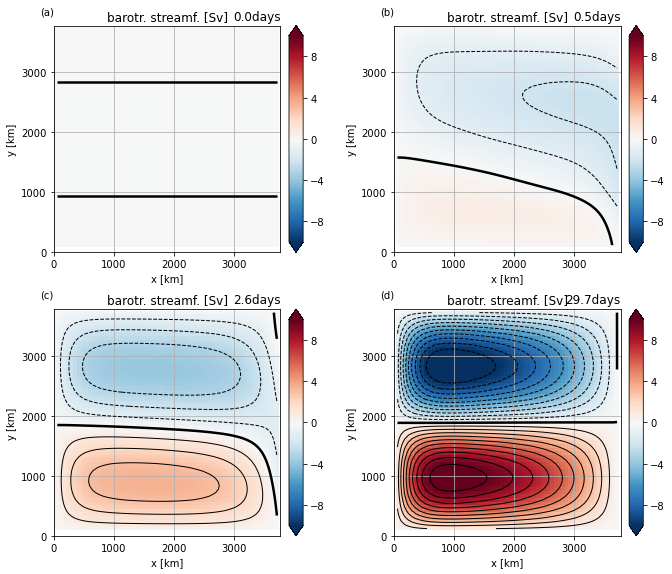

In [12]:
# prepare the animation
iz = 0
steps = [0, 1, 5, 57]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=1., fig_size_fac=2, 
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    vo = ds.vo[ll,iz,:,:].to_masked_array()
    bstr = (vo*H0*dx).cumsum(axis=1)/1e6
    # clim = 'sym'
    clim = 10
    hm = shade(xu/1e3, yu/1e3, bstr, ax=ax, cax=cax, clim=clim, conts=np.linspace(-10,10,21))
    ax.set_title('barotr. streamf. [Sv]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
    ax.grid(True)

## Make an animation

In [13]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/shallowpy_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

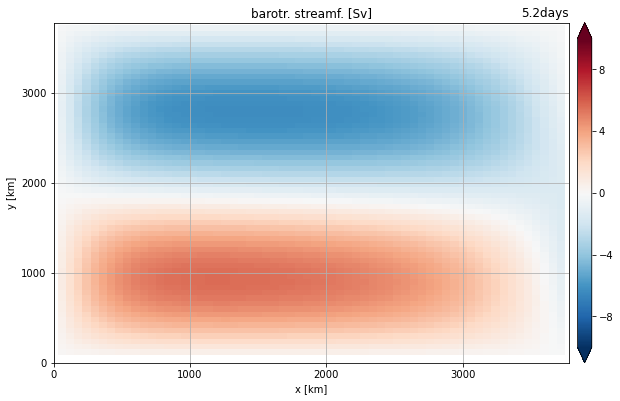

In [14]:
# prepare the animation

iz = 0
ll=10

hca, hcb = arrange_axes(1,1, plot_cb=True, asp=0.66, fig_size_fac=3, axlab_kw=None,
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
vo = ds.vo[ll,iz,:,:].to_masked_array()
bstr = (vo*H0*dx).cumsum(axis=1)/1e6
clim = 10
hm = shade(xu/1e3, yu/1e3, bstr, ax=ax, cax=cax, clim=clim)
ax.set_title('barotr. streamf. [Sv]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')
ax.grid(True)

In [15]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    vo = ds.vo[ll,iz,:,:].to_masked_array()
    bstr = (vo*H0*dx).cumsum(axis=1)/1e6
    hm[0].set_array(bstr.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [16]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/wind_gyre///wind_gyre.mp4
CPU times: user 2.97 s, sys: 170 ms, total: 3.14 s
Wall time: 3.15 s


## Showing the animation

In [17]:
%%time
HTML(ani.to_jshtml())

CPU times: user 3.76 s, sys: 159 ms, total: 3.92 s
Wall time: 3.98 s
